In [236]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

import json
from collections import defaultdict


from generate_plots import find_results_json_files, reconcile_results_into_dataframe, get_obfuscation_stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
labeled_bc_dir = pathlib.Path('/home/nika/Desktop/sip_dataset/LABELED-BCs')

df = reconcile_results_into_dataframe(find_results_json_files(labeled_bc_dir))

In [203]:
df

,data_source,obfuscation,features,sc_guard,cfi_verify,oh_verify,none
0,mibench-cov,BC30+IS2+FLA2,seg + tf_idf + ir2vec,0.135700,0.160790,0.131530,0.784017
1,mibench-cov,BC30+IS2+FLA2,seg + tf_idf + code2vec,0.829268,0.438073,0.788419,0.977784
2,mibench-cov,BC30+IS2+FLA2,seg + tf_idf,0.098323,0.113772,0.098729,0.660062
3,mibench-cov,BC30+IS2+FLA2,seg,0.084577,0.093253,0.105605,0.540289
4,mibench-cov,BC30+IS2+FLA2,code2vec,0.717149,0.482051,0.353716,0.957391
...,...,...,...,...,...,...,...
1612,simple-cov,FLA+IS+BC30,seg + tf_idf + code2vec,0.234295,0.151351,0.405405,0.944152
1613,simple-cov,FLA+IS+BC30,seg + tf_idf,0.097059,0.095238,0.305206,0.891100
1614,simple-cov,FLA+IS+BC30,seg,0.104784,0.062669,0.217593,0.847163
1615,simple-cov,FLA+IS+BC30,code2vec,0.388430,0.091435,0.430859,0.923849


In [204]:
results_table = df.groupby(['data_source', 'obfuscation', 'features'])\
.agg({
    'none': ['mean', 'std'], 
    'sc_guard': ['mean', 'std'], 
    'cfi_verify': ['mean', 'std'], 
    'oh_verify': ['mean', 'std']
}).reset_index()

In [240]:
simple_df = results_table[results_table['data_source'] == 'simple-cov']

simple_df.to_csv('simple_results.csv', index=False)

In [206]:
mibench_df = results_table[results_table['data_source'] == 'mibench-cov']
mibench_df

data_source obfuscation                          features      none  \
                                                                    mean   
0    mibench-cov       BC100                          code2vec  0.994693   
1    mibench-cov       BC100                               seg  0.973756   
2    mibench-cov       BC100                      seg + tf_idf  0.983849   
3    mibench-cov       BC100           seg + tf_idf + code2vec  0.996197   
4    mibench-cov       BC100  seg + tf_idf + code2vec + ir2vec  0.995331   
..           ...         ...                               ...       ...   
228  mibench-cov        NONE                               seg  0.931901   
229  mibench-cov        NONE                      seg + tf_idf  0.942772   
230  mibench-cov        NONE           seg + tf_idf + code2vec  0.972129   
231  mibench-cov        NONE  seg + tf_idf + code2vec + ir2vec  0.987220   
232  mibench-cov        NONE             seg + tf_idf + ir2vec  0.975448   

               sc_guard           cfi_verify           oh_verify            
          std      mean       std       mean       std      mean       std  
0    0.002763  0.923313  0.101990   0.954617  0.030698  0.794553  0.080300  
1    0.003373  0.644856  0.059205   0.691762  0.116722  0.470786  0.081767  
2    0.005085  0.445289  0.479297   0.778876  0.133177  0.544929  0.076032  
3    0.001805  0.984812  0.015676   0.971525  0.009736  0.811094  0.073272  
4    0.002020  0.995059  0.007503   0.956136  0.043306  0.762750  0.100239  
..        ...       ...       ...        ...       ...       ...       ...  
228  0.035872  0.896830  0.061537   0.745709  0.134692  0.594685  0.126707  
229  0.009836  0.701274  0.227398   0.778164  0.097005  0.001214  0.002427  
230  0.026447  0.953786  0.066153   0.826200  0.210129  0.839838  0.099300  
231  0.007825  0.997787  0.003705   0.884876  0.123288  0.905333  0.056208  
232  0.013324  0.996751  0.003730   0.856510  0.141717  0.811078  0.085010  

[233 rows x 11 columns]

In [207]:
df['features'].unique()

array(['seg + tf_idf + ir2vec', 'seg + tf_idf + code2vec', 'seg + tf_idf',
       'seg', 'code2vec', 'seg + tf_idf + code2vec + ir2vec'],
      dtype=object)

In [208]:
def get_plot_results(df, data_source, protection):

    """
    {
        # obfuscation --> feature results
        'None': {
            'original': [0.98, 0.99, 0.99, ...],
            'no_tf_idf': [],
            'ir2vec': []
        },
        'IS': {
            'original': [...],
            'no_tf_idf': [...],
            'ir2vec': [...]
        },
        'FLA': {
            'original': [...],
            'no_tf_idf': [...],
            'ir2vec': [...]
        }
    }
    """
    plot_results = defaultdict(dict)
    for _, row in df.iterrows():
        if row['data_source'] != data_source:
            continue
        
        obfuscation = row['obfuscation']
        features = row['features']
        
        if features not in plot_results[obfuscation]:
            plot_results[obfuscation][features] = []
        
        plot_results[obfuscation][features].append(row[protection])
        
    return plot_results

In [180]:
def draw_plot(data_labels, data_values, plot_names, title, file_name):    
    label_a, label_b, label_c = plot_names
    data_a, data_b, data_c = data_values
    ticks = data_labels 

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
    
    figsize_x = 3 if 'simple' in file_name else 4
    plt.figure(figsize=(len(ticks)//2, figsize_x), dpi=200)

    # bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    # bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)


    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a))) - 0.15, sym='', widths=0.08)
    bpm = plt.boxplot(data_b, positions=np.array(range(len(data_b))),       sym='', widths=0.08)
    bpr = plt.boxplot(data_c, positions=np.array(range(len(data_c))) + 0.15, sym='', widths=0.08)

    set_box_color(bpl, '#A9A9A9') # colors are from http://colorbrewer2.org/
    set_box_color(bpm, '#228B22')
    set_box_color(bpr, '#FF0000')

    plt.plot([], c='#A9A9A9', label=label_a)
    plt.plot([], c='#228B22', label=label_b)
    plt.plot([], c='#FF0000', label=label_c)
    plt.legend(loc=4, prop={'size': 6})

    plt.title(title)
    
    plt.xticks(range(0, len(ticks)), ticks, size=6)
    plt.xlim(-0.5, len(ticks))
    plt.ylim(0, 1.1)
    plt.tight_layout()
    
    ax = plt.gca()
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig(file_name)

In [209]:
def median(nums):
    return sorted(nums)[len(nums)//2]

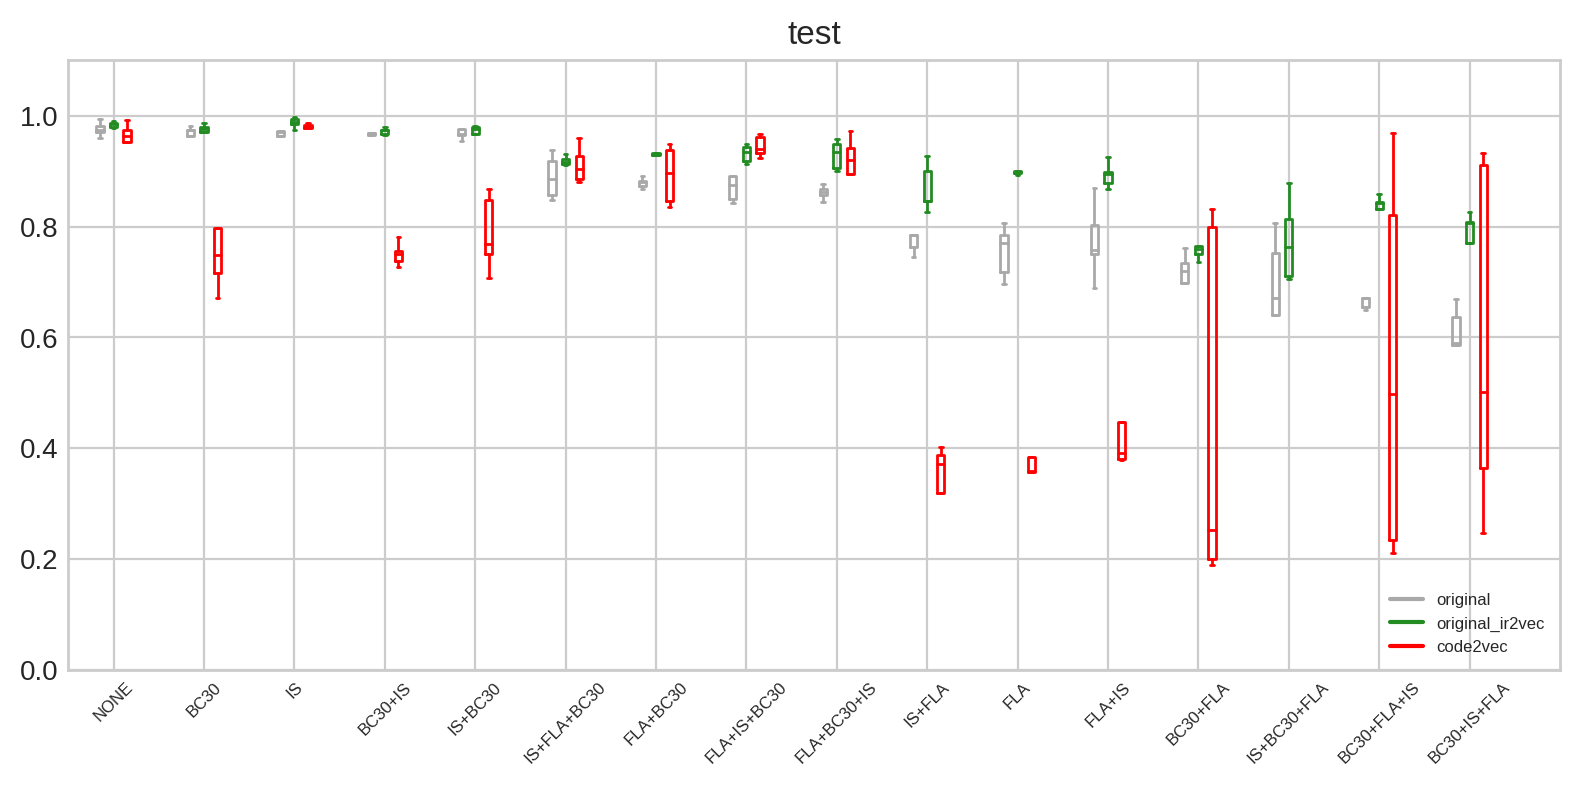

In [210]:
plot_results = get_plot_results(df, 'simple-cov', 'none')


data_labels = sorted(
    plot_results.keys(), 
    key=lambda key: median(plot_results[key]['seg + tf_idf']),
    reverse=True
)
data_values_original = [plot_results[label]['seg + tf_idf'] for label in data_labels]
data_values_with_ir2vec = [plot_results[label]['seg + tf_idf + ir2vec'] for label in data_labels]
data_values_code2vec = [plot_results[label]['code2vec'] for label in data_labels]


data_values = [data_values_original, data_values_with_ir2vec, data_values_code2vec]
draw_plot(data_labels, data_values, ['original', 'original_ir2vec', 'code2vec'], 'test', 'asasd')

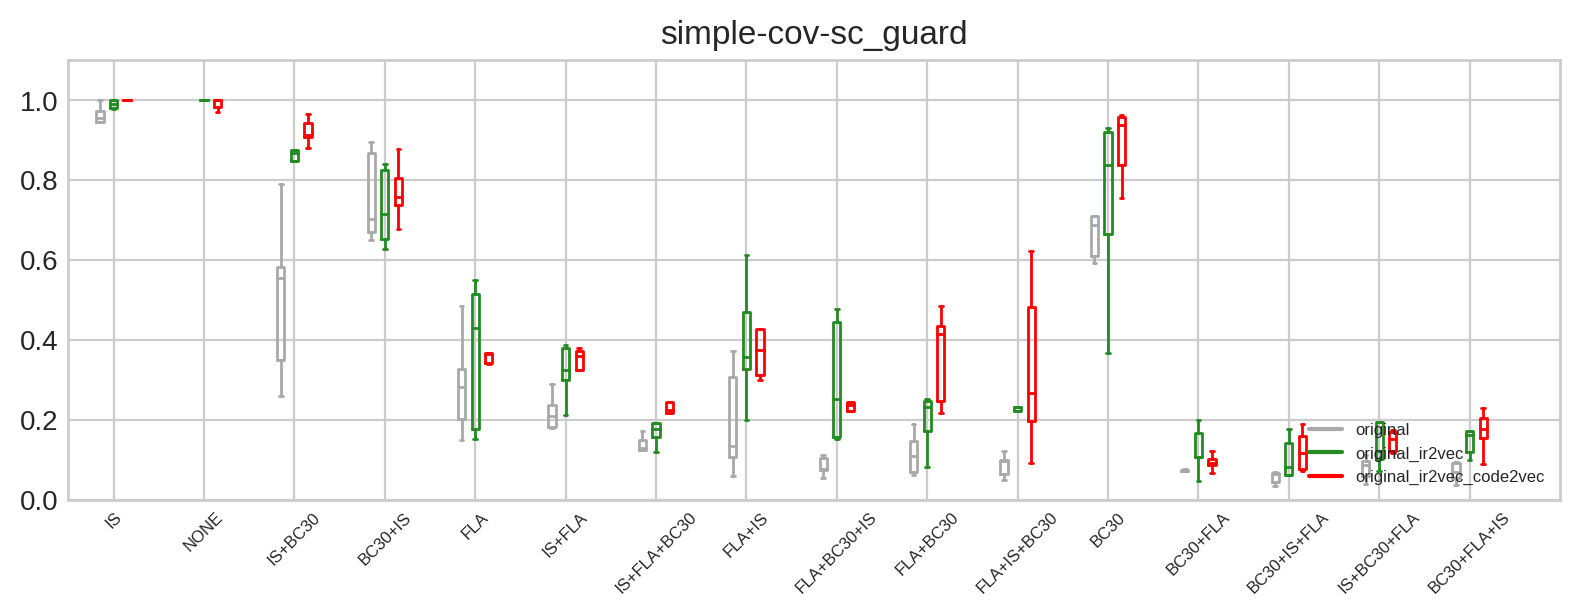

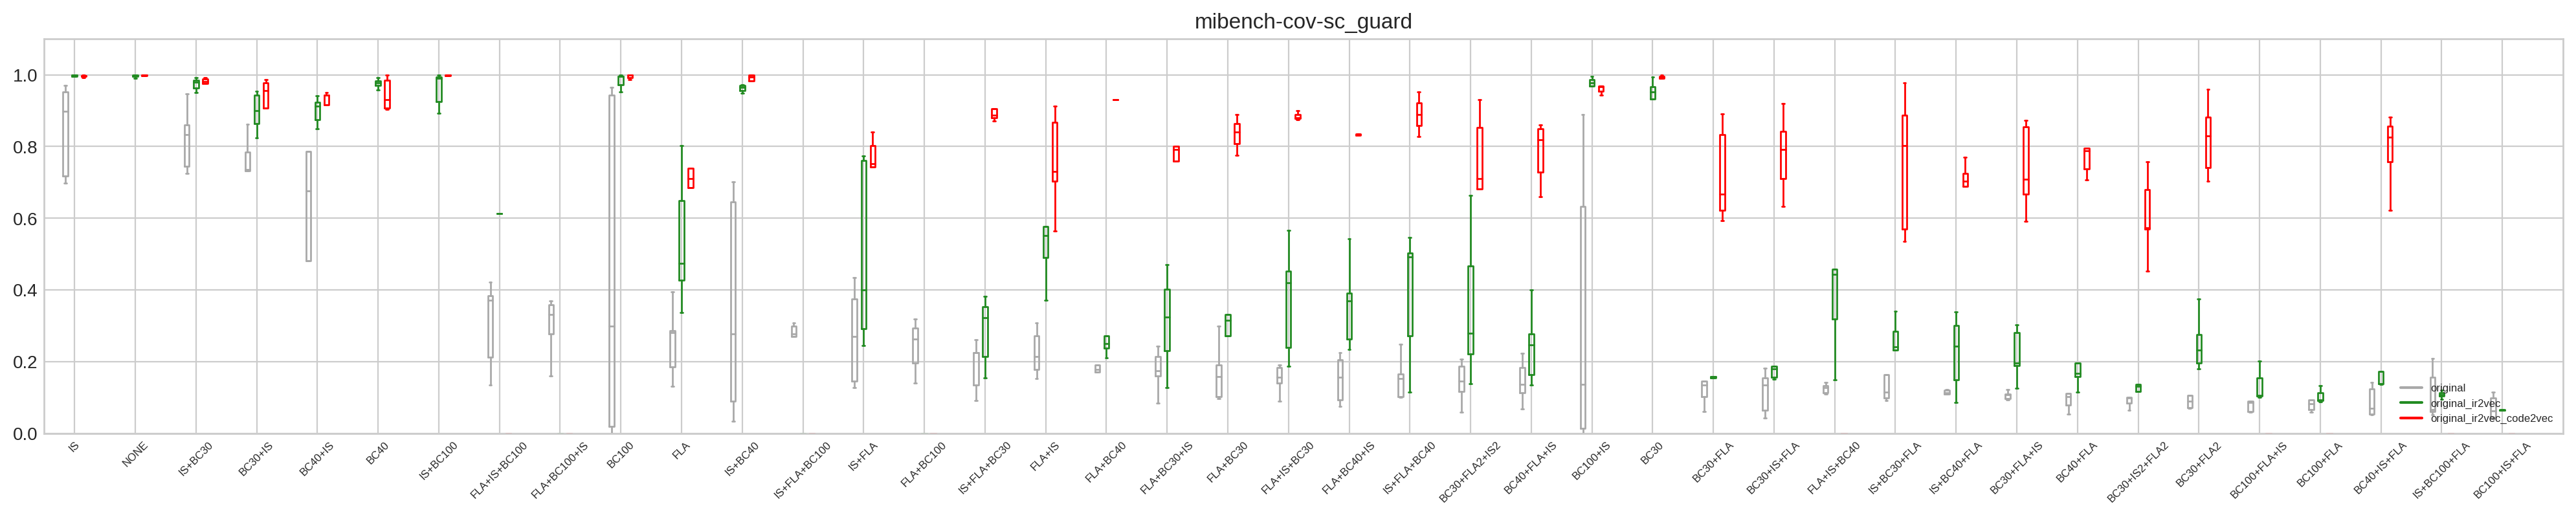

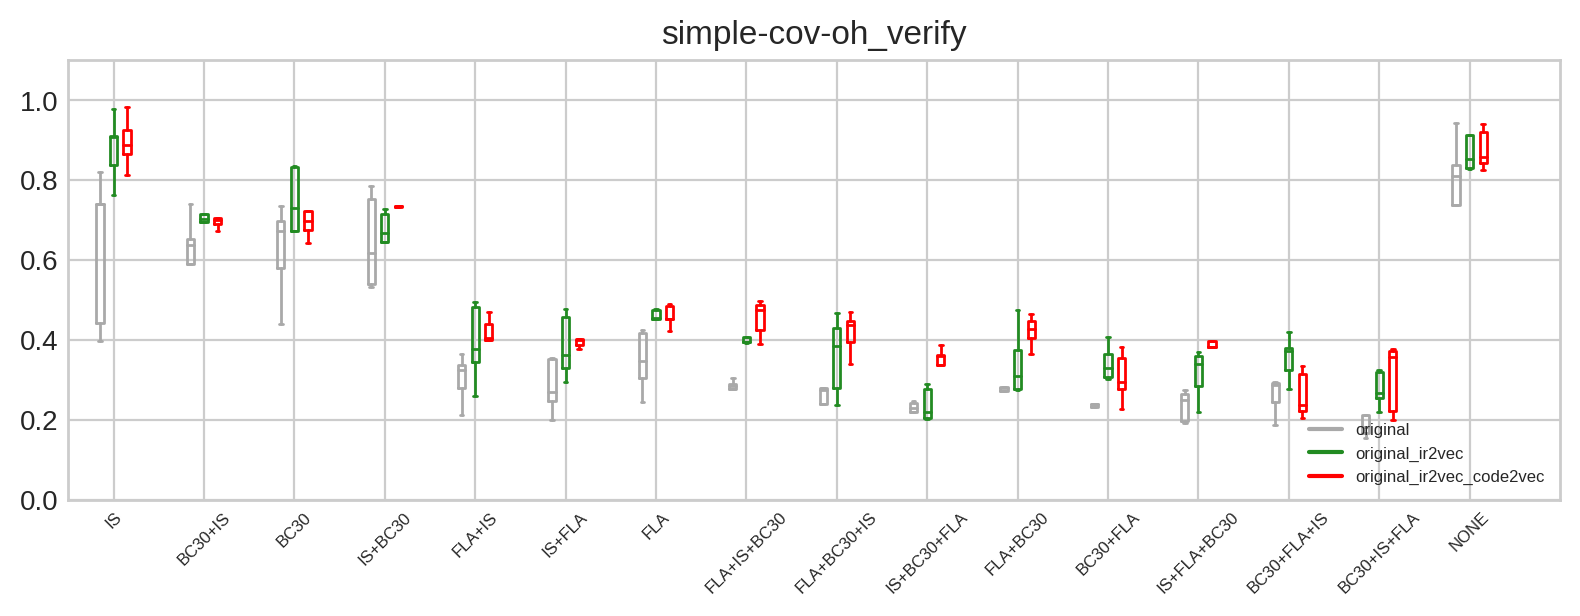

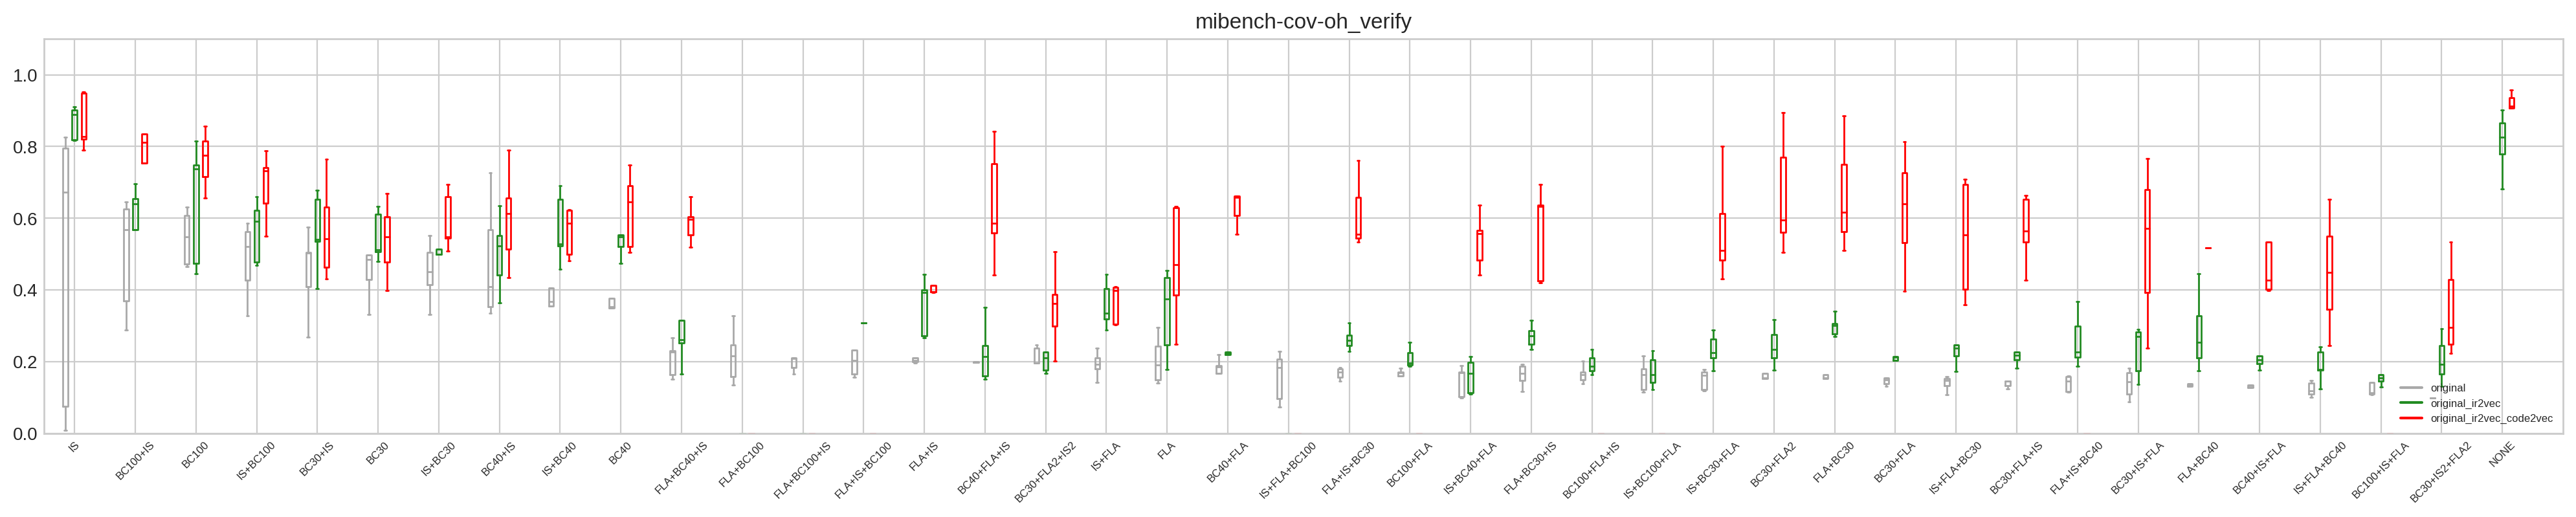

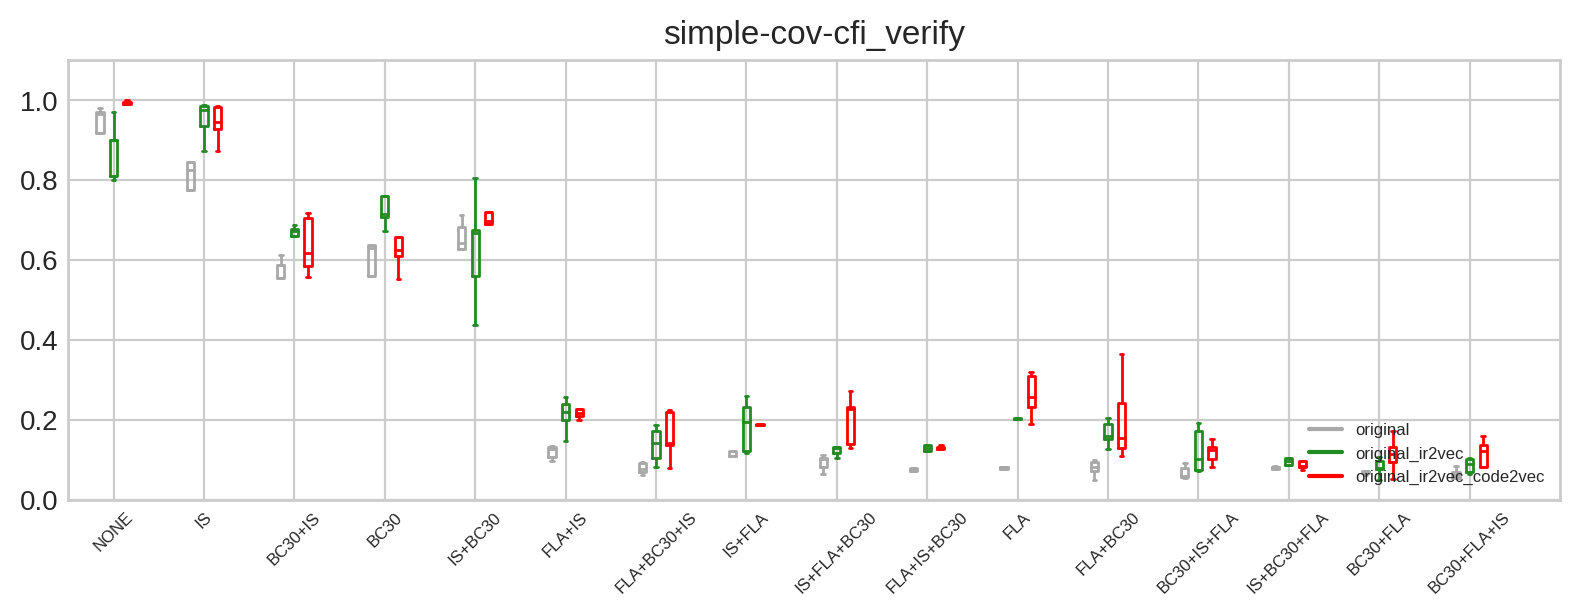

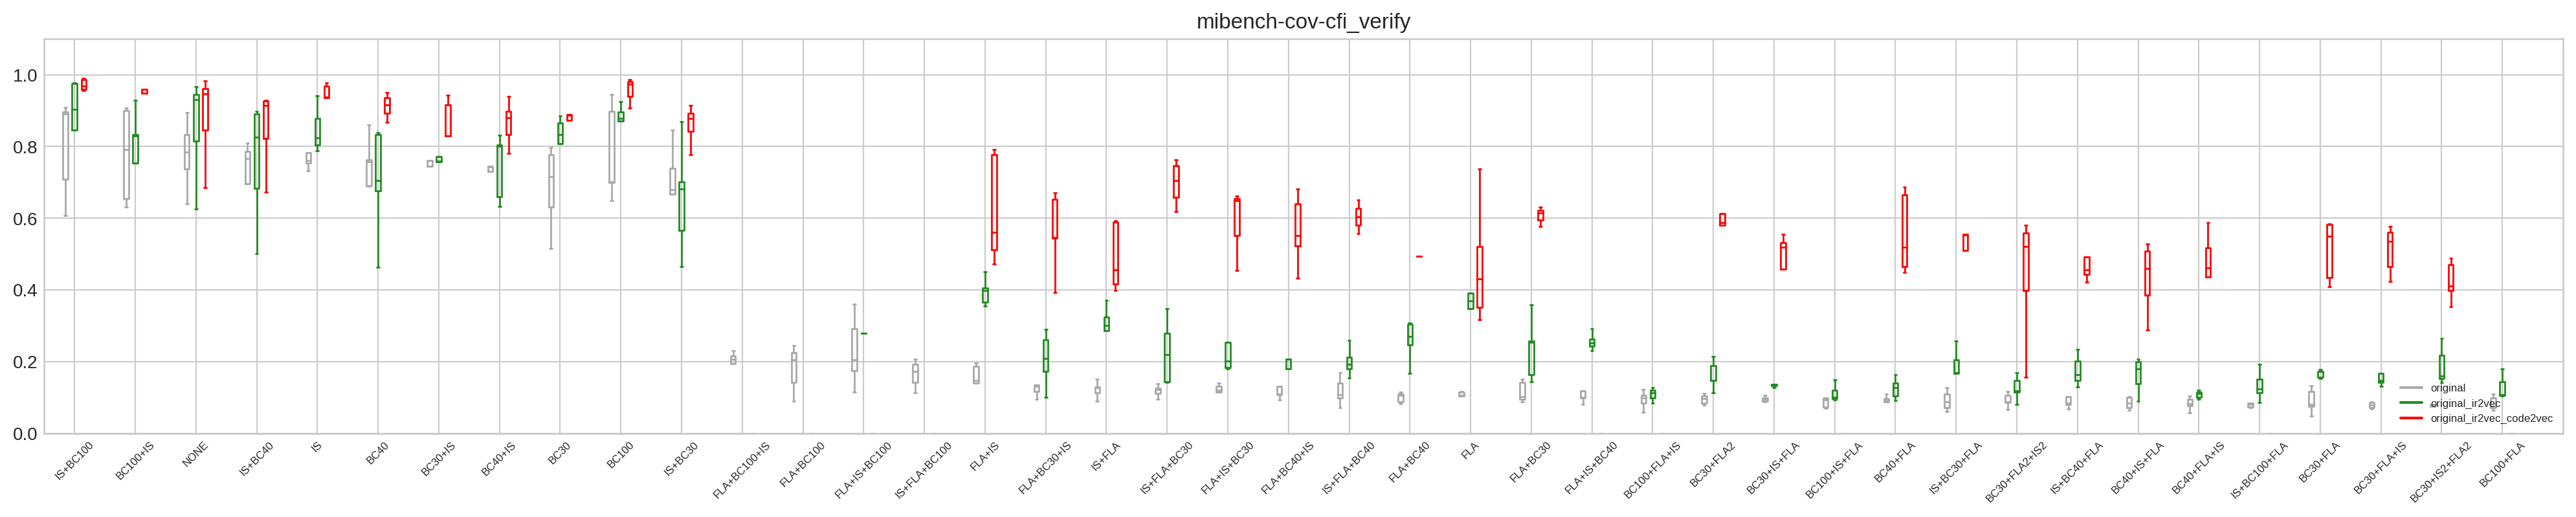

In [211]:
for protection in ['sc_guard', 'oh_verify', 'cfi_verify']:
    mibench_plot_results = get_plot_results(df, 'mibench-cov', protection)
    mibench_data_labels = sorted(
        mibench_plot_results.keys(), 
        key=lambda key: median(mibench_plot_results[key]['seg + tf_idf']),
        reverse=True
    )
    
    for src_dataset in ['simple-cov', 'mibench-cov']:
        plot_results = get_plot_results(df, src_dataset, protection)
        
        data_labels = sorted(plot_results.keys(), key=lambda key: mibench_data_labels.index(key) if key in mibench_data_labels else len(mibench_data_labels))

        data_values_original = [plot_results[label]['seg + tf_idf'] for label in data_labels]
        data_values_with_ir2vec = [plot_results[label].get('seg + tf_idf + ir2vec', 0.0) for label in data_labels]
        data_values_code2vec = [plot_results[label].get('seg + tf_idf + code2vec + ir2vec', 0.0) for label in data_labels]

        plot_title = f'{src_dataset}-{protection}'
        file_name = f'plots/{plot_title}.pdf'
        plot_labels = ['original', 'original_ir2vec', 'original_ir2vec_code2vec']
        data_values = [data_values_original, data_values_with_ir2vec, data_values_code2vec]
        
        draw_plot(data_labels, data_values, plot_labels, plot_title, file_name)

## Dataset Stats

In [212]:
obfs_stats_df = get_obfuscation_stats(labeled_bc_dir)

In [213]:
obfs_stats = {}
for _, row in obfs_stats_df.iterrows():
    obfs = row['Obfuscation']
    obfs_stats[obfs] = row['Avg % IR Lines Incr.']
obfs_stats

{'NONE': 0.0,
 'IS': 22.400944269579703,
 'FLA': 107.75782262543973,
 'BC30': 113.76134049250139,
 'FLA+IS': 130.84382521755228,
 'IS+FLA': 132.31114608405852,
 'BC30+IS': 204.1589520459174,
 'IS+BC30': 209.83151268283655,
 'BC30+FLA': 302.83512312534714,
 'IS+BC30+FLA': 373.7155156452509,
 'FLA+BC30': 408.8941862618034,
 'BC30+FLA+IS': 434.1672838363266,
 'BC30+IS+FLA': 449.122847620811,
 'FLA+IS+BC30': 477.50416589520466,
 'IS+FLA+BC30': 484.1047954082578,
 'BC40': 523.8482883286721,
 'FLA+BC30+IS': 604.1080355489725,
 'IS+BC40': 727.629386370945,
 'BC40+IS': 745.6681998460326,
 'BC30+FLA2': 909.0452304154202,
 'BC40+FLA': 942.0972237110087,
 'BC100': 1006.3542082850155,
 'FLA+BC40': 1323.4133055282161,
 'IS+BC40+FLA': 1347.941779787369,
 'BC40+FLA+IS': 1349.7241008000467,
 'BC40+IS+FLA': 1437.948990927606,
 'FLA+IS+BC40': 1527.280644909812,
 'IS+BC100': 1585.2851323828922,
 'BC100+IS': 1677.8652101462694,
 'IS+FLA+BC40': 1700.4101336009903,
 'BC100+FLA': 1898.470556134829,
 'FLA+BC4

## Scatter Plots

In [220]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['figure.dpi'] = 200

# plt.figure(figsize=(12, 8), dpi=200)


import numpy as np

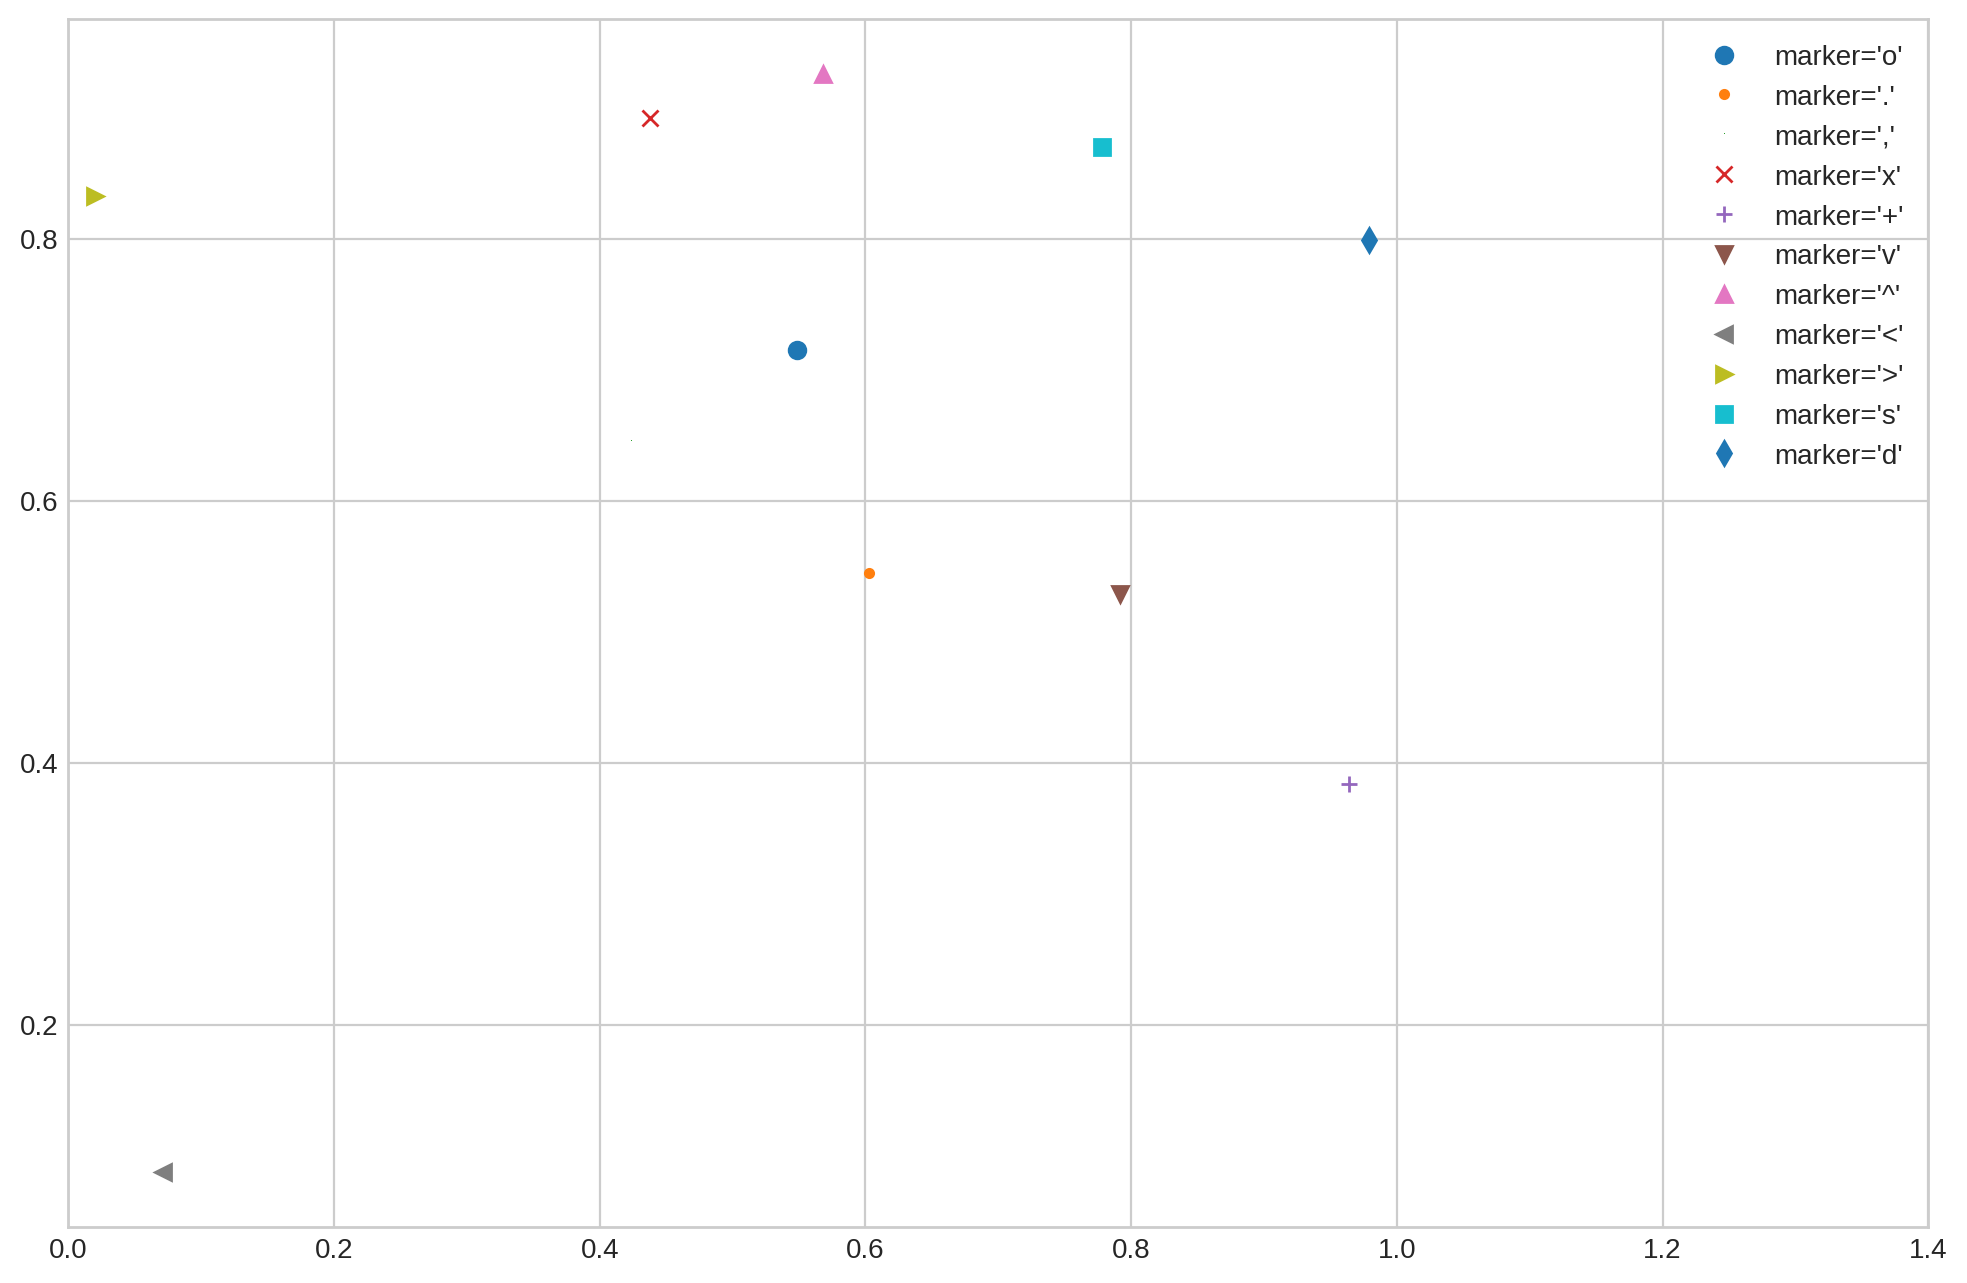

In [221]:
rng = np.random.RandomState(0)
for marker in ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']:
    plt.plot(rng.rand(), rng.rand(), marker, label=f"marker='{marker}'")

plt.legend(numpoints=1)
plt.xlim(0, 1.4);

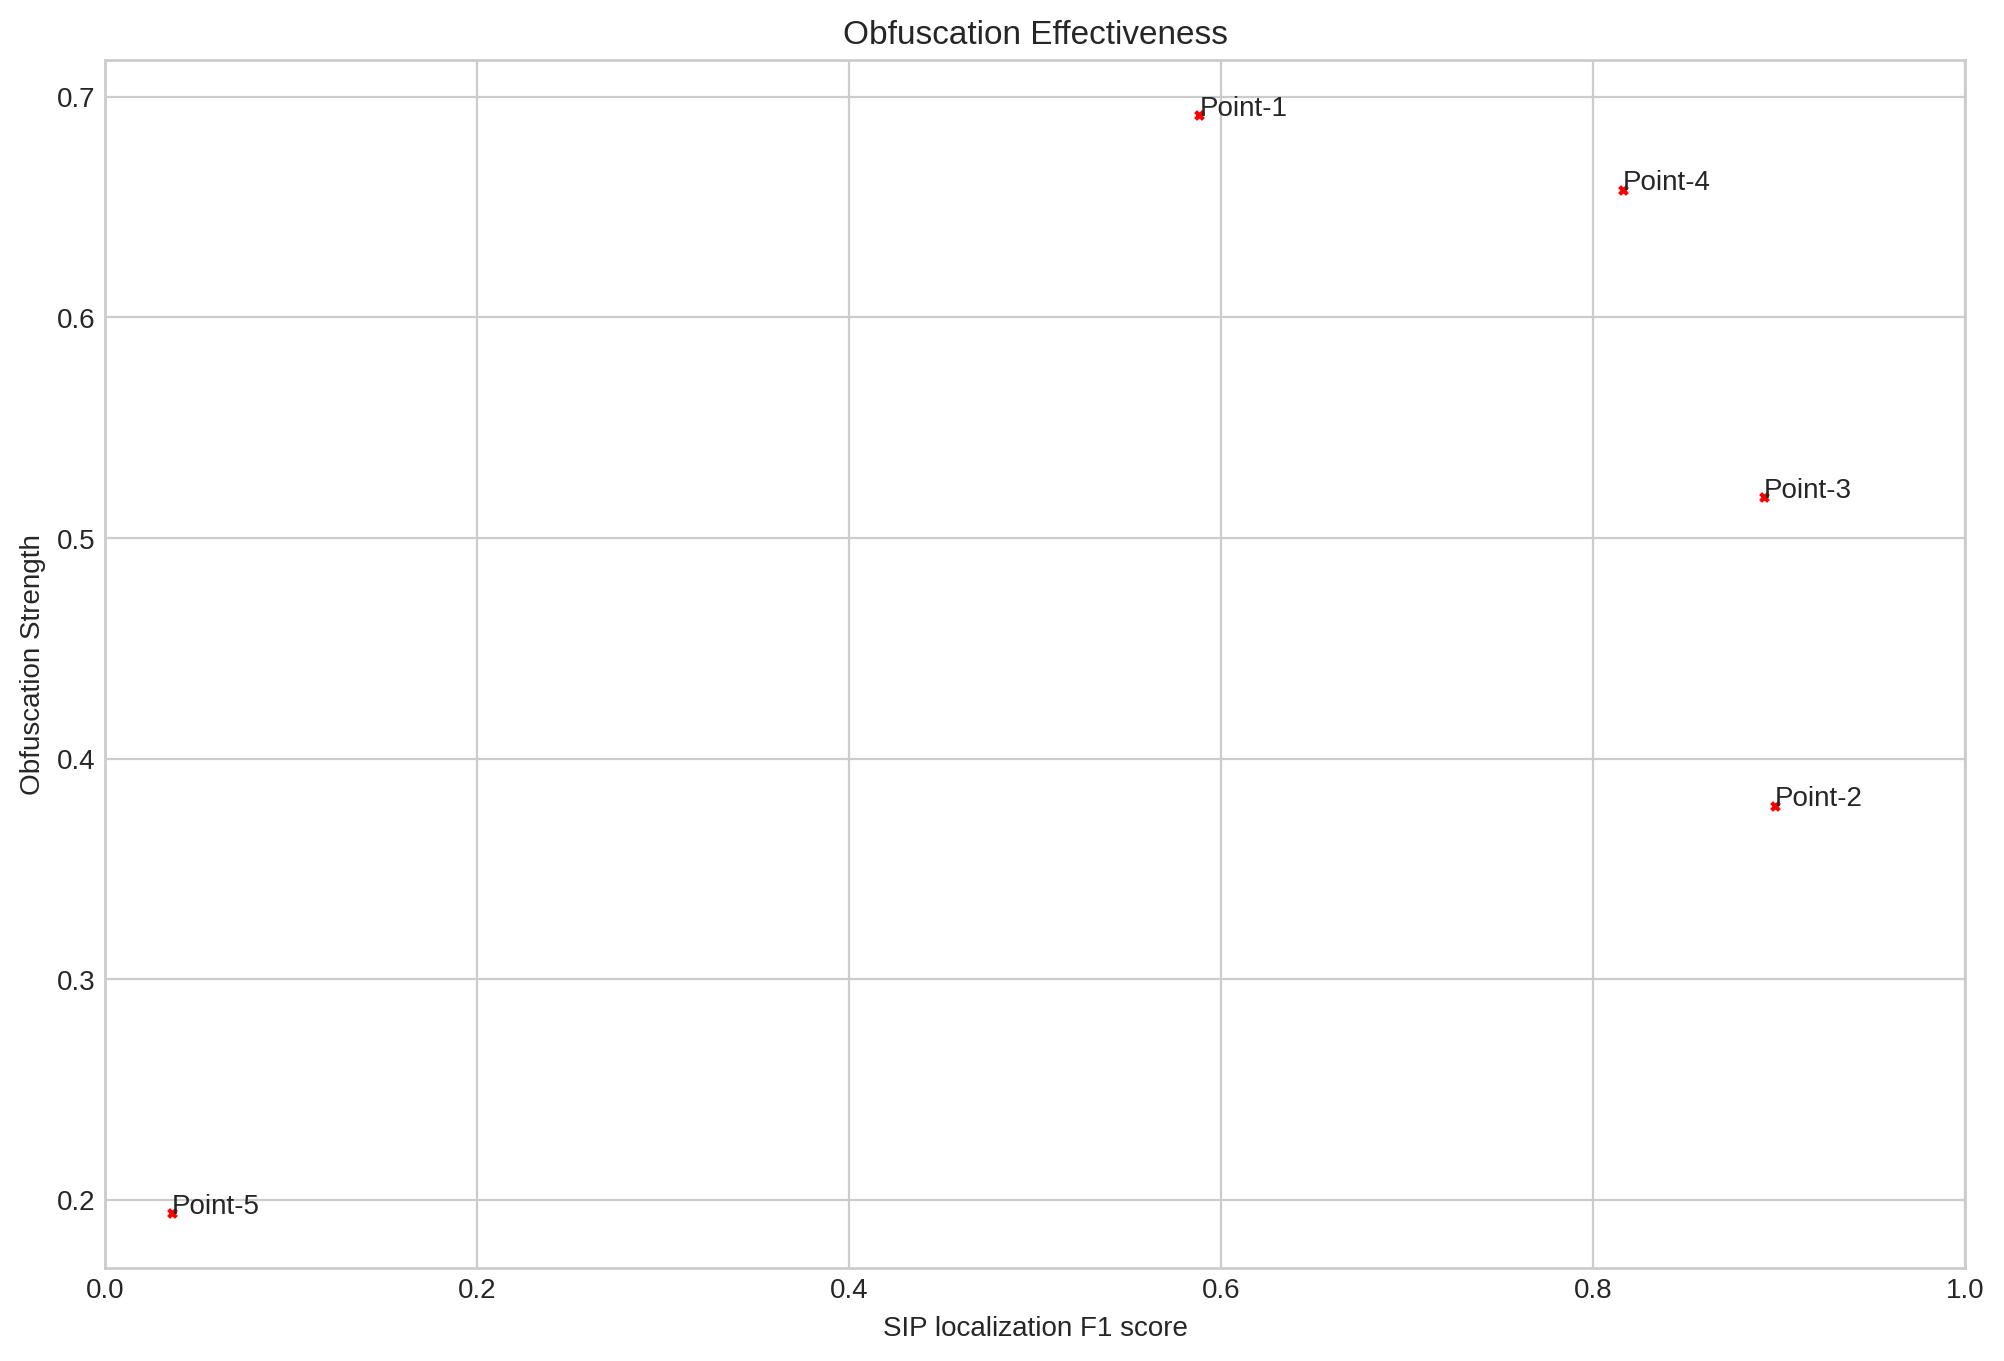

In [227]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.rand(5)
Y=np.random.rand(5)

annotations = ['Point-1', 'Point-2', 'Point-3', 'Point-4', 'Point-5']

plt.figure(figsize=(12, 8), dpi=200)

# markers ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']

plt.scatter(X,Y, s=8, color="red", marker='x')
plt.xlabel("SIP localization F1 score")
plt.ylabel("Obfuscation Strength")
plt.title("Obfuscation Effectiveness",fontsize=12)
for i, label in enumerate(annotations):
    plt.text(X[i], Y[i],label)

plt.xlim(0, 1);
plt.xlim(0, 1);

plt.show()

In [228]:
def draw_scatter_plot(f1_score_dict, obfuscation_strength_dict, title):
    obfuscations = list(f1_score_dict.keys())
    
    X = [f1_score_dict[k] for k in obfuscations]
    Y = [obfuscation_strength_dict[k] for k in obfuscations]
    
    plt.scatter(X, Y, s=8, color='red', marker='x')
    plt.xlabel('SIP localization F1 score')
    plt.ylabel('Avg % IR Lines Incr.')
    plt.title(title, fontsize=16)
    
    
    for i, label in enumerate(obfuscations):
        plt.text(X[i], Y[i], label)

#     plt.xlim(min(f1_score_dict.values()), max(f1_score_dict.values()));
    plt.xlim(0, 1.0)
    plt.ylim(min(X), max(Y));

    plt.show()

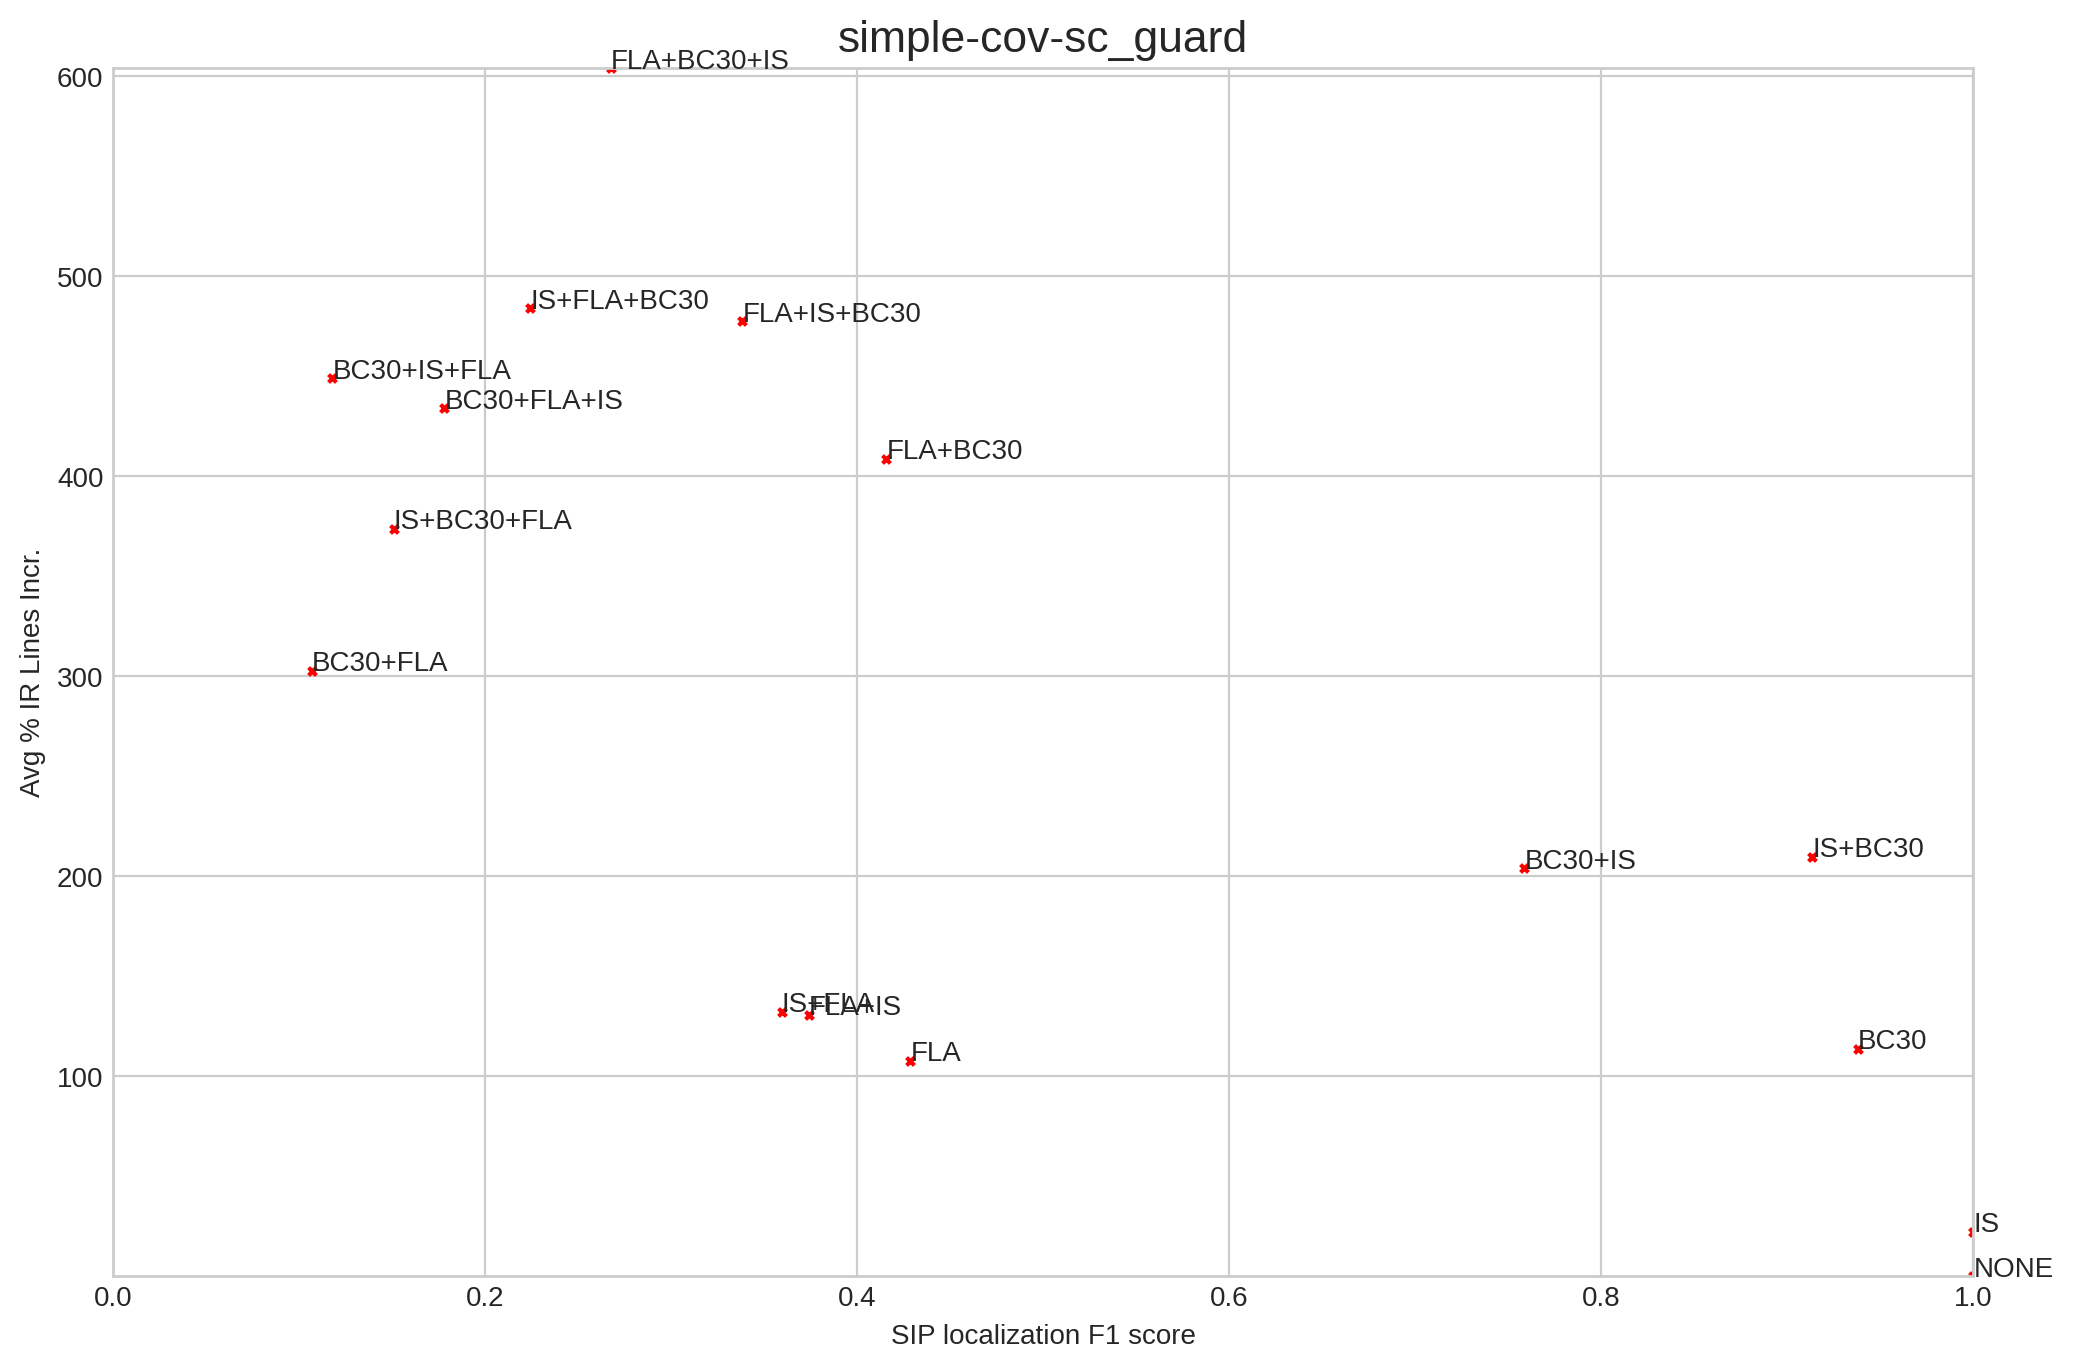

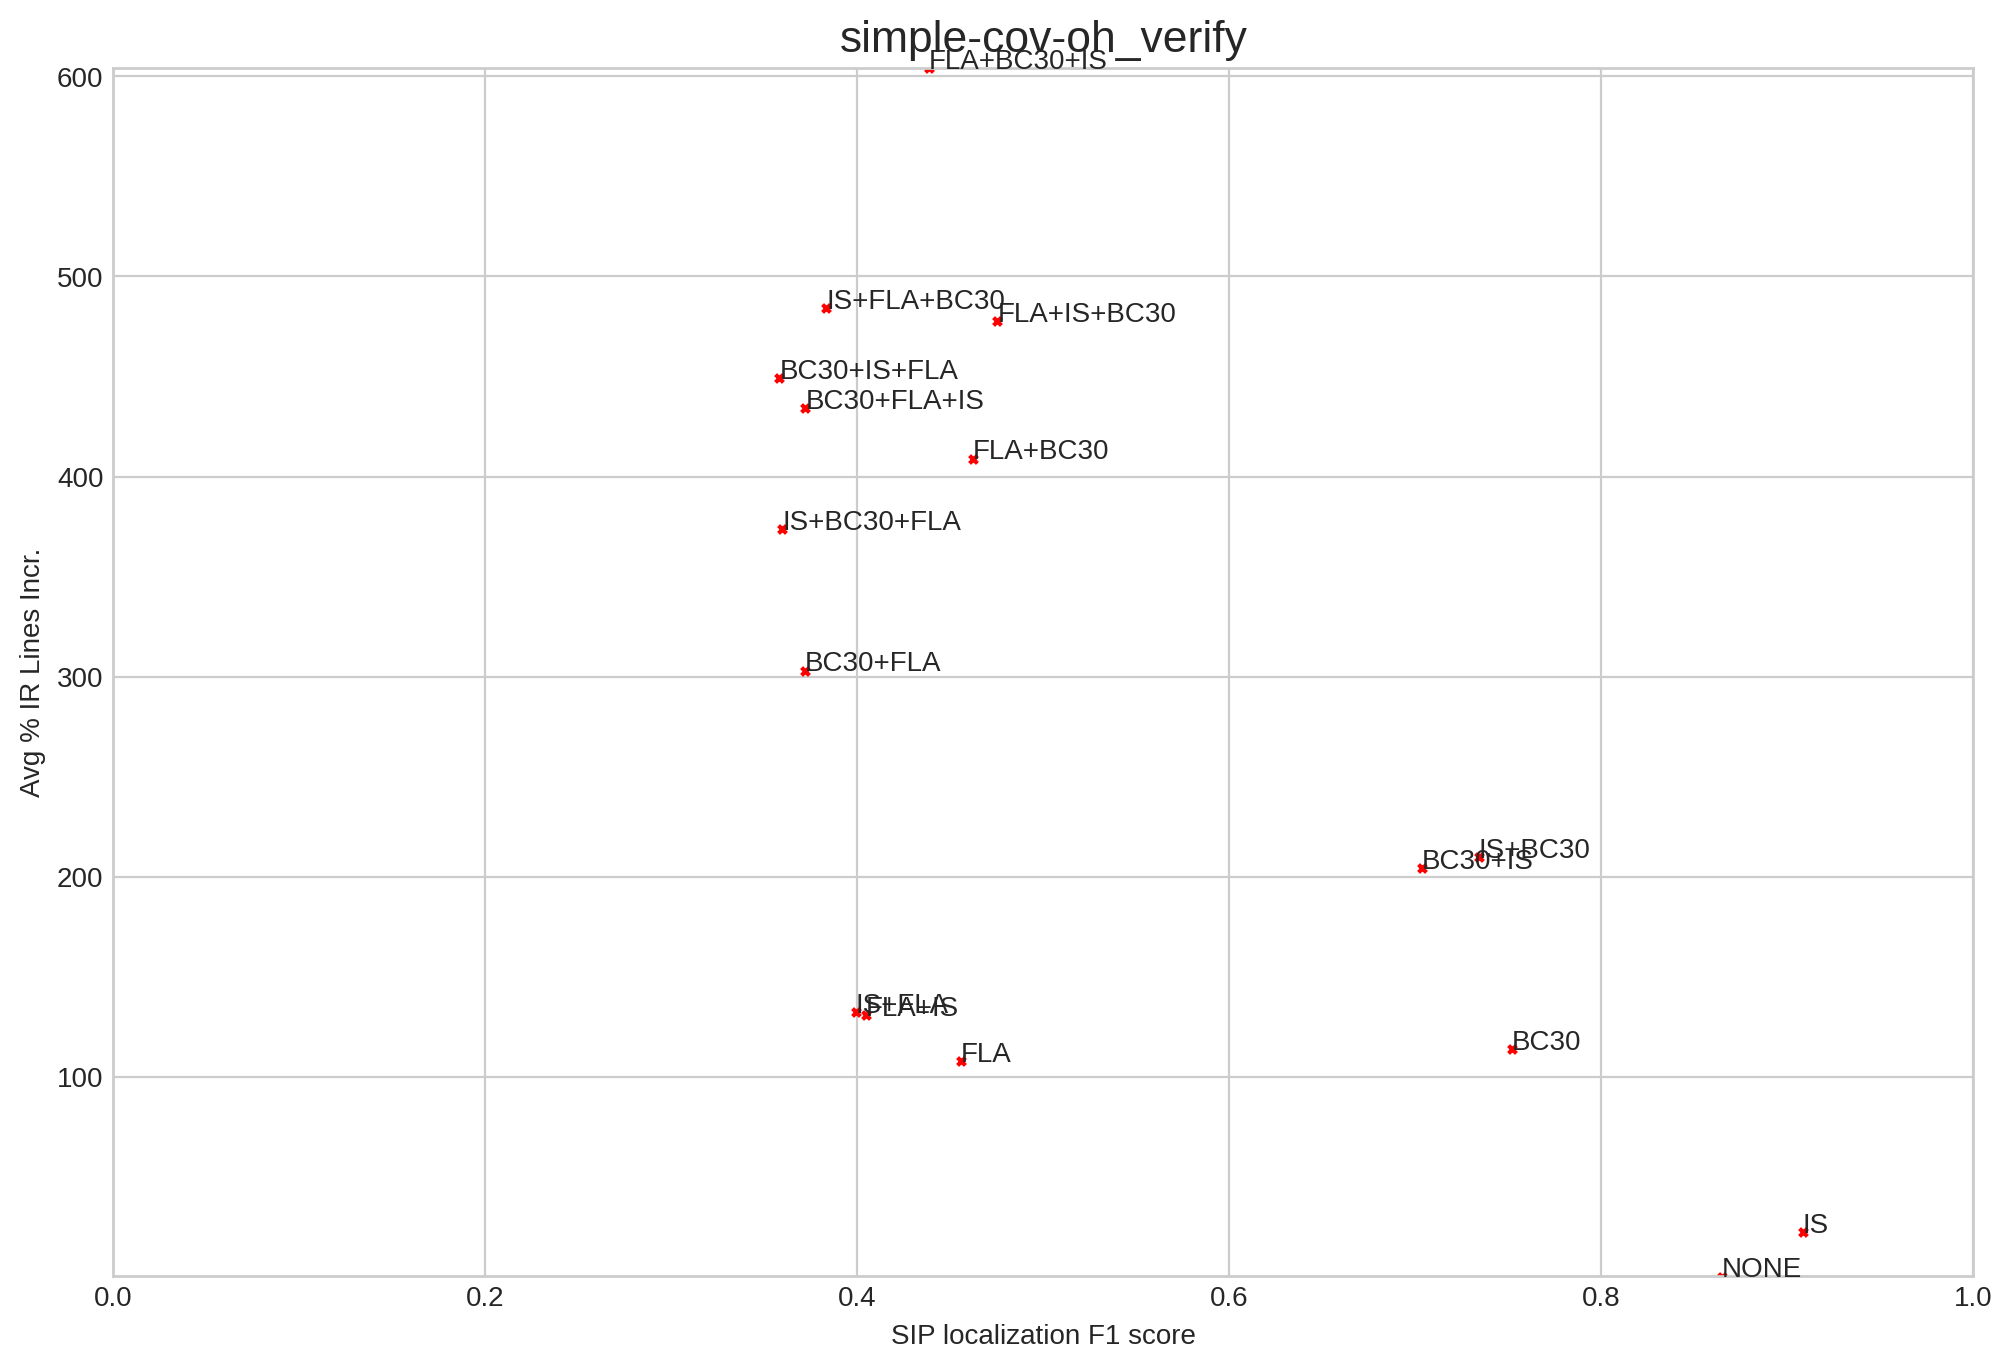

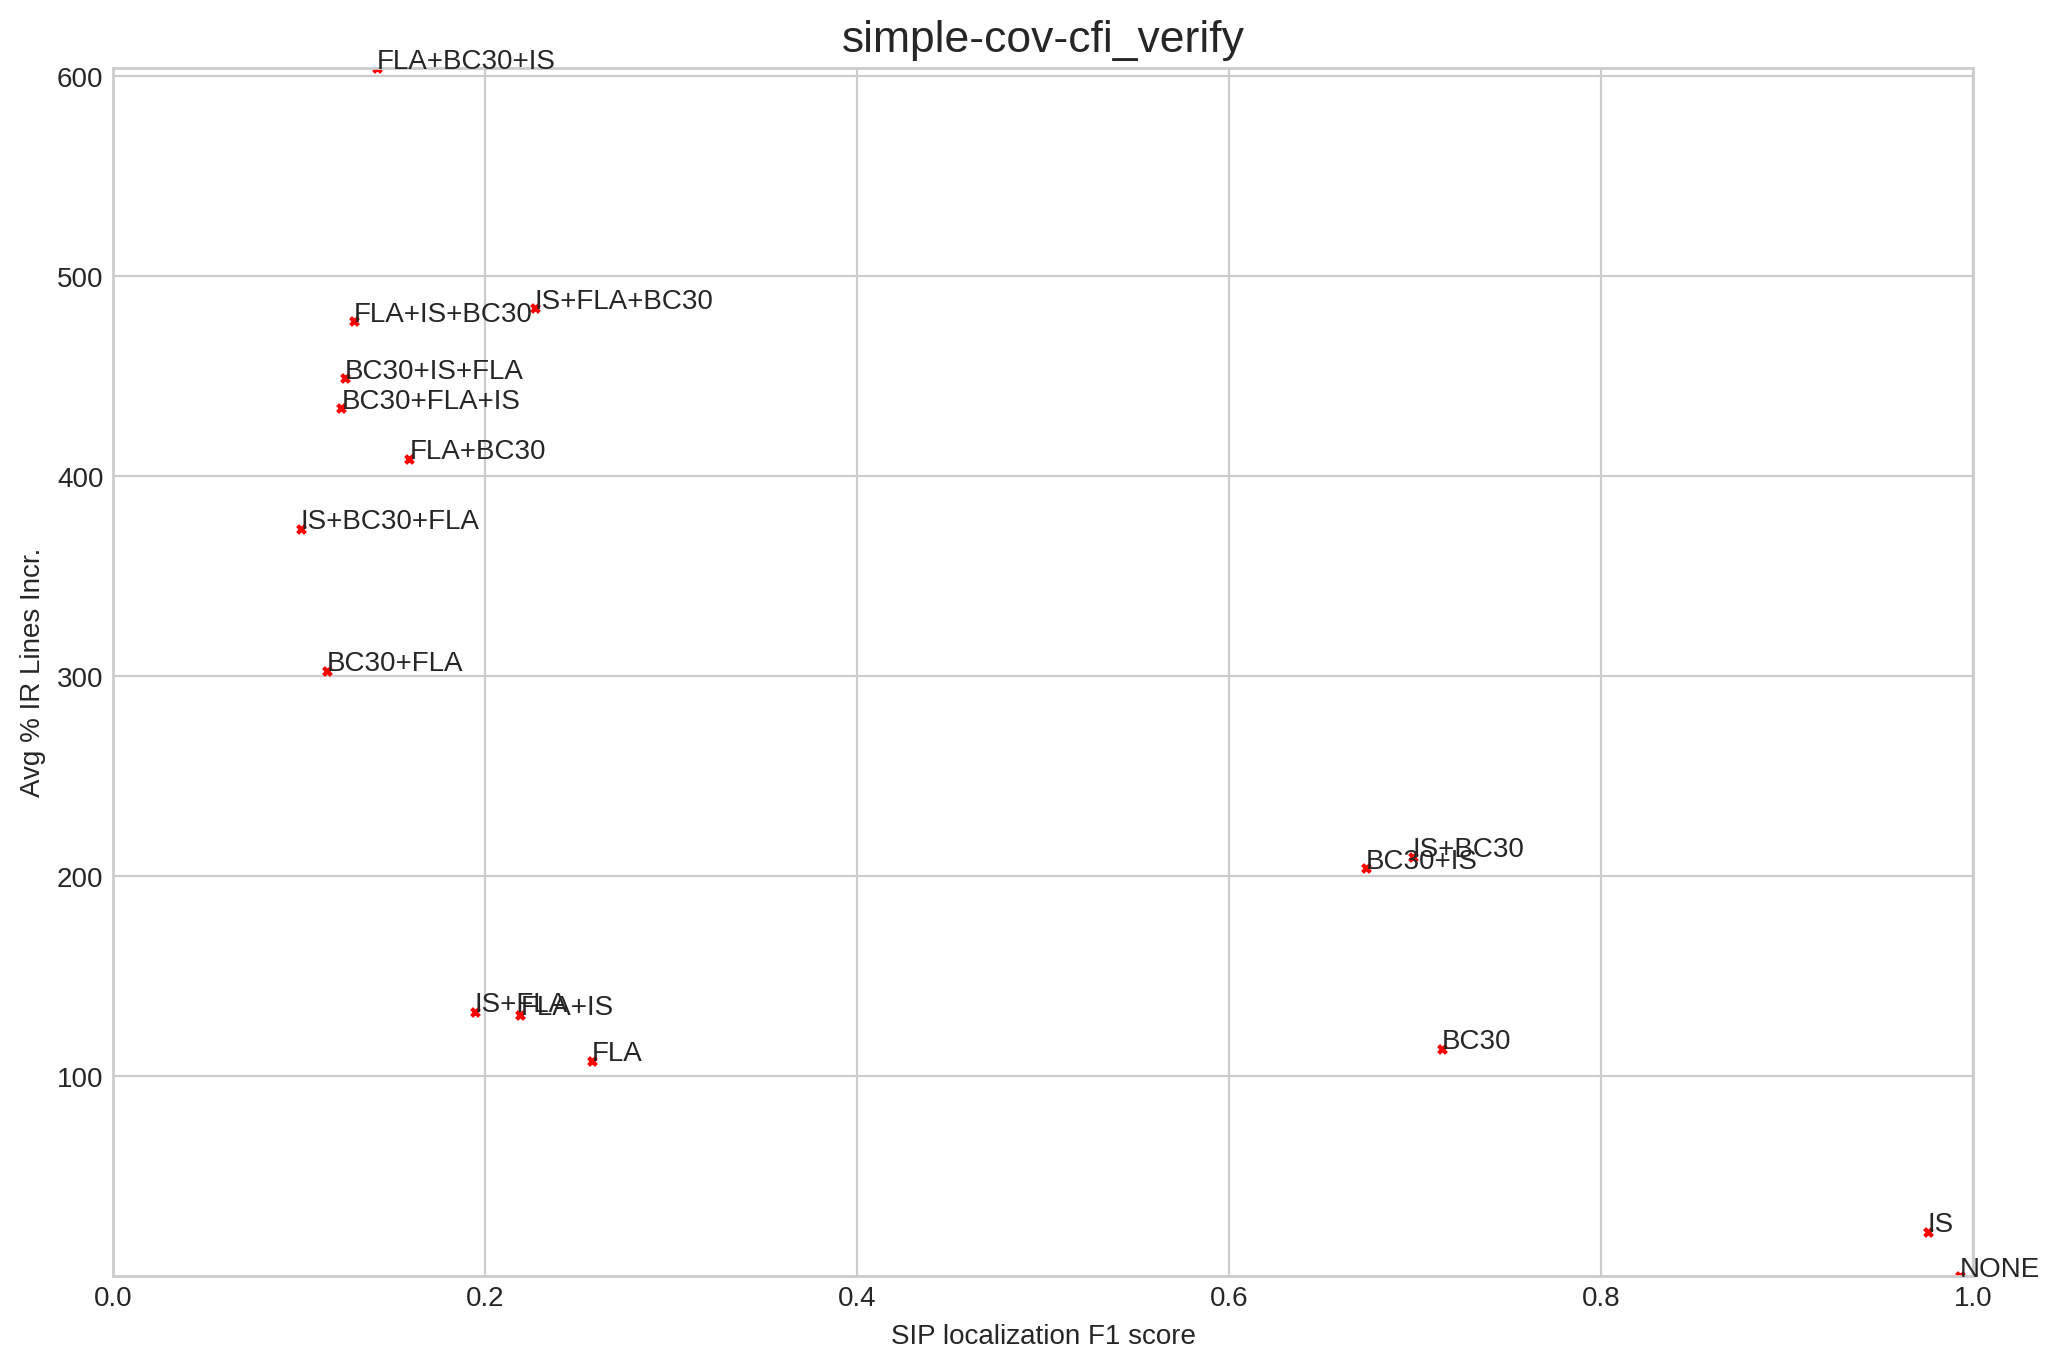

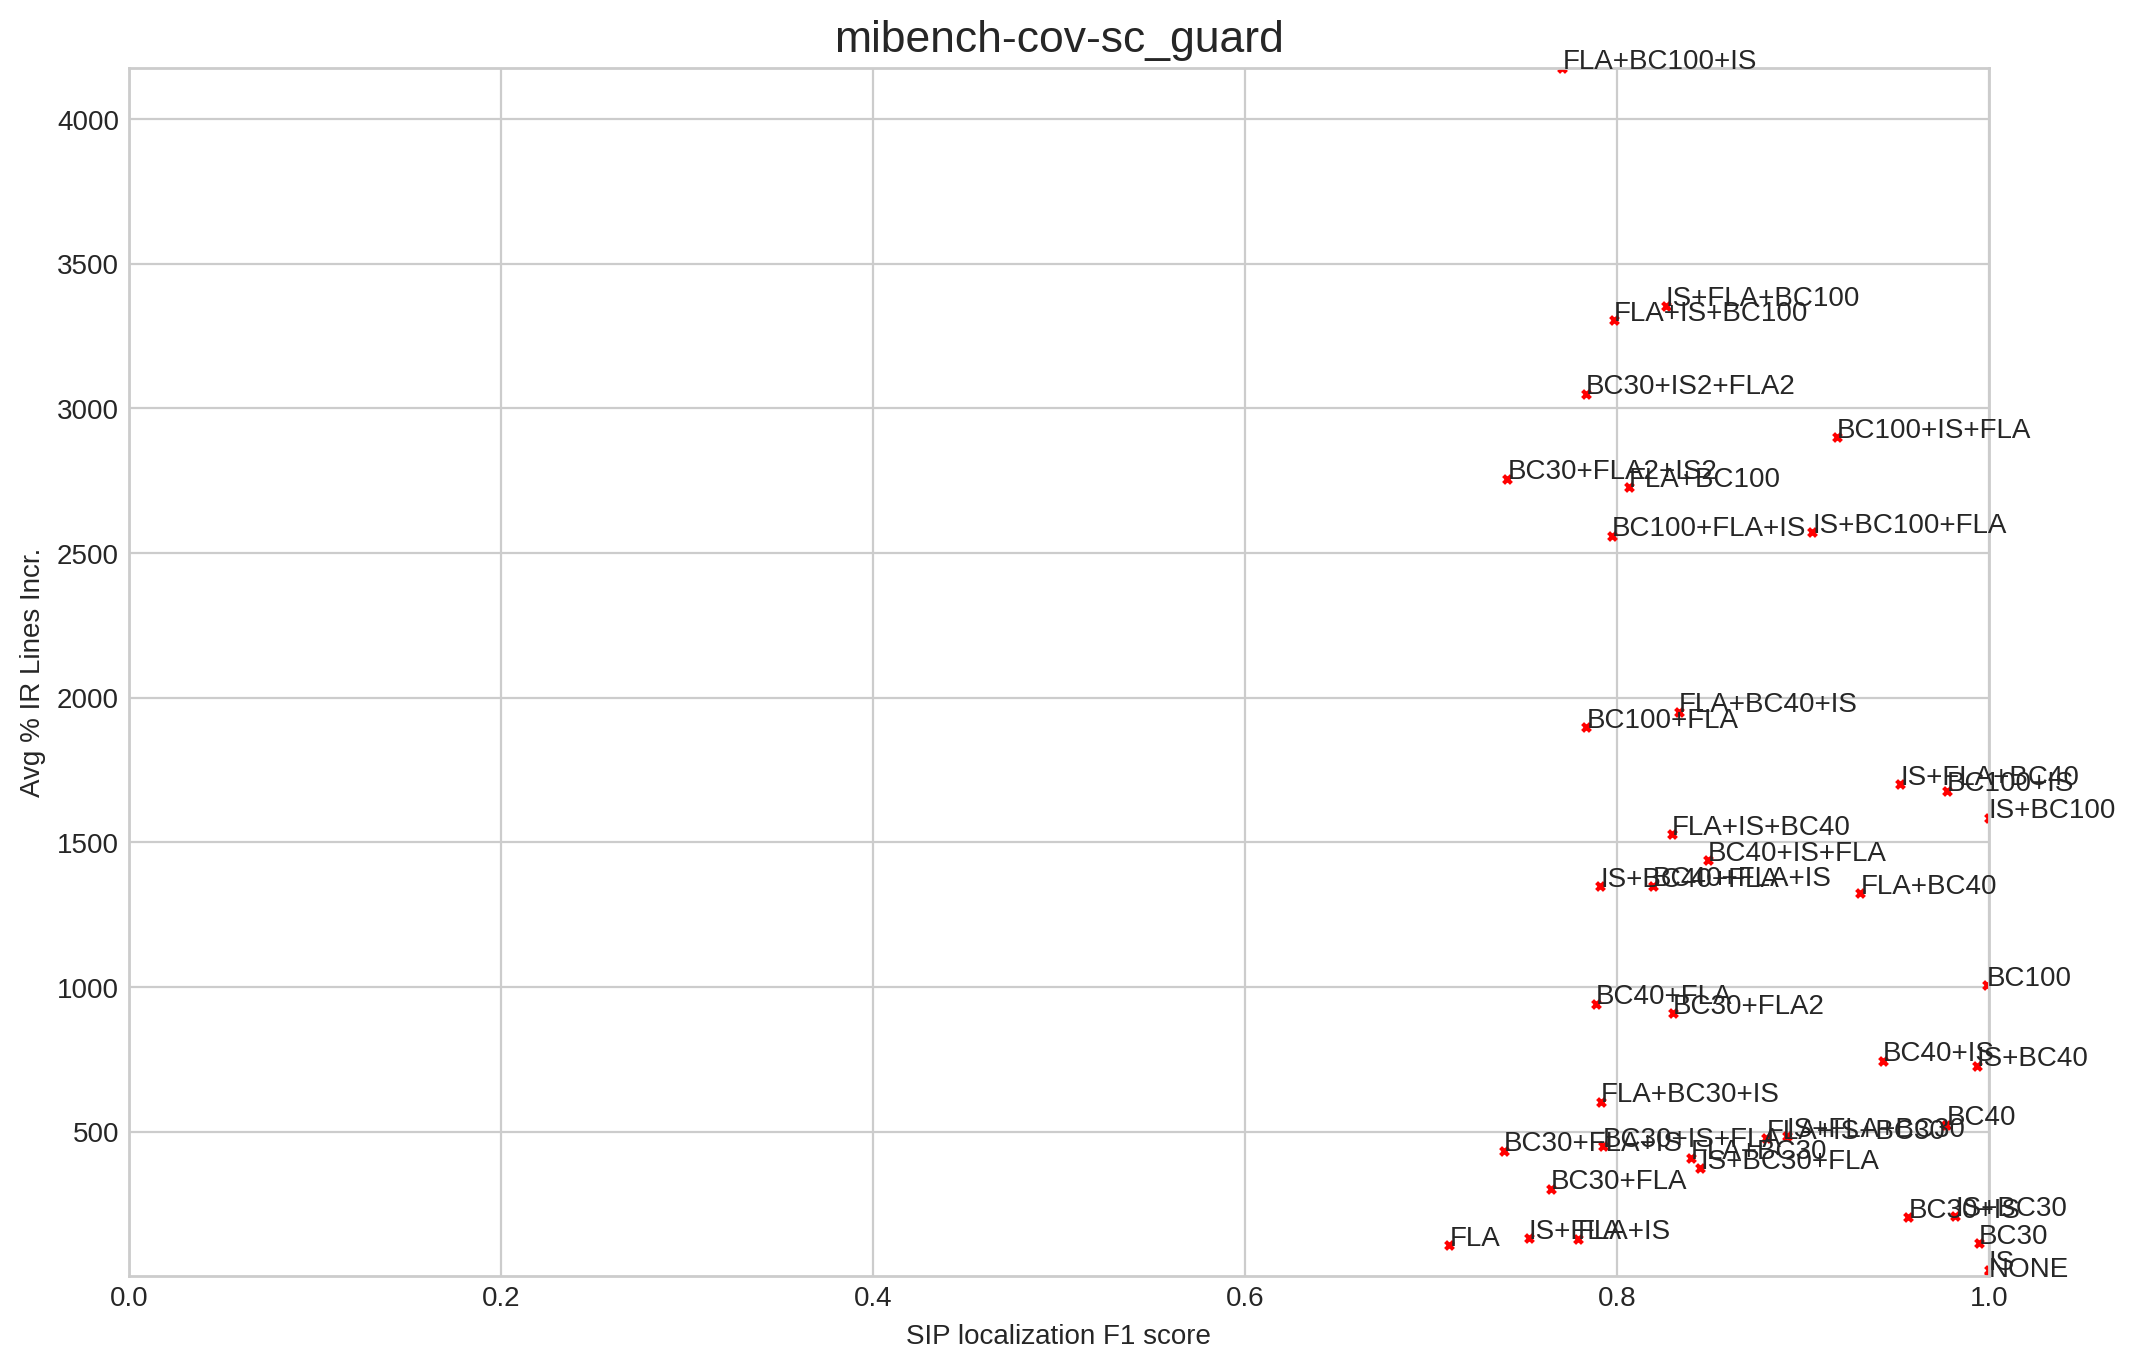

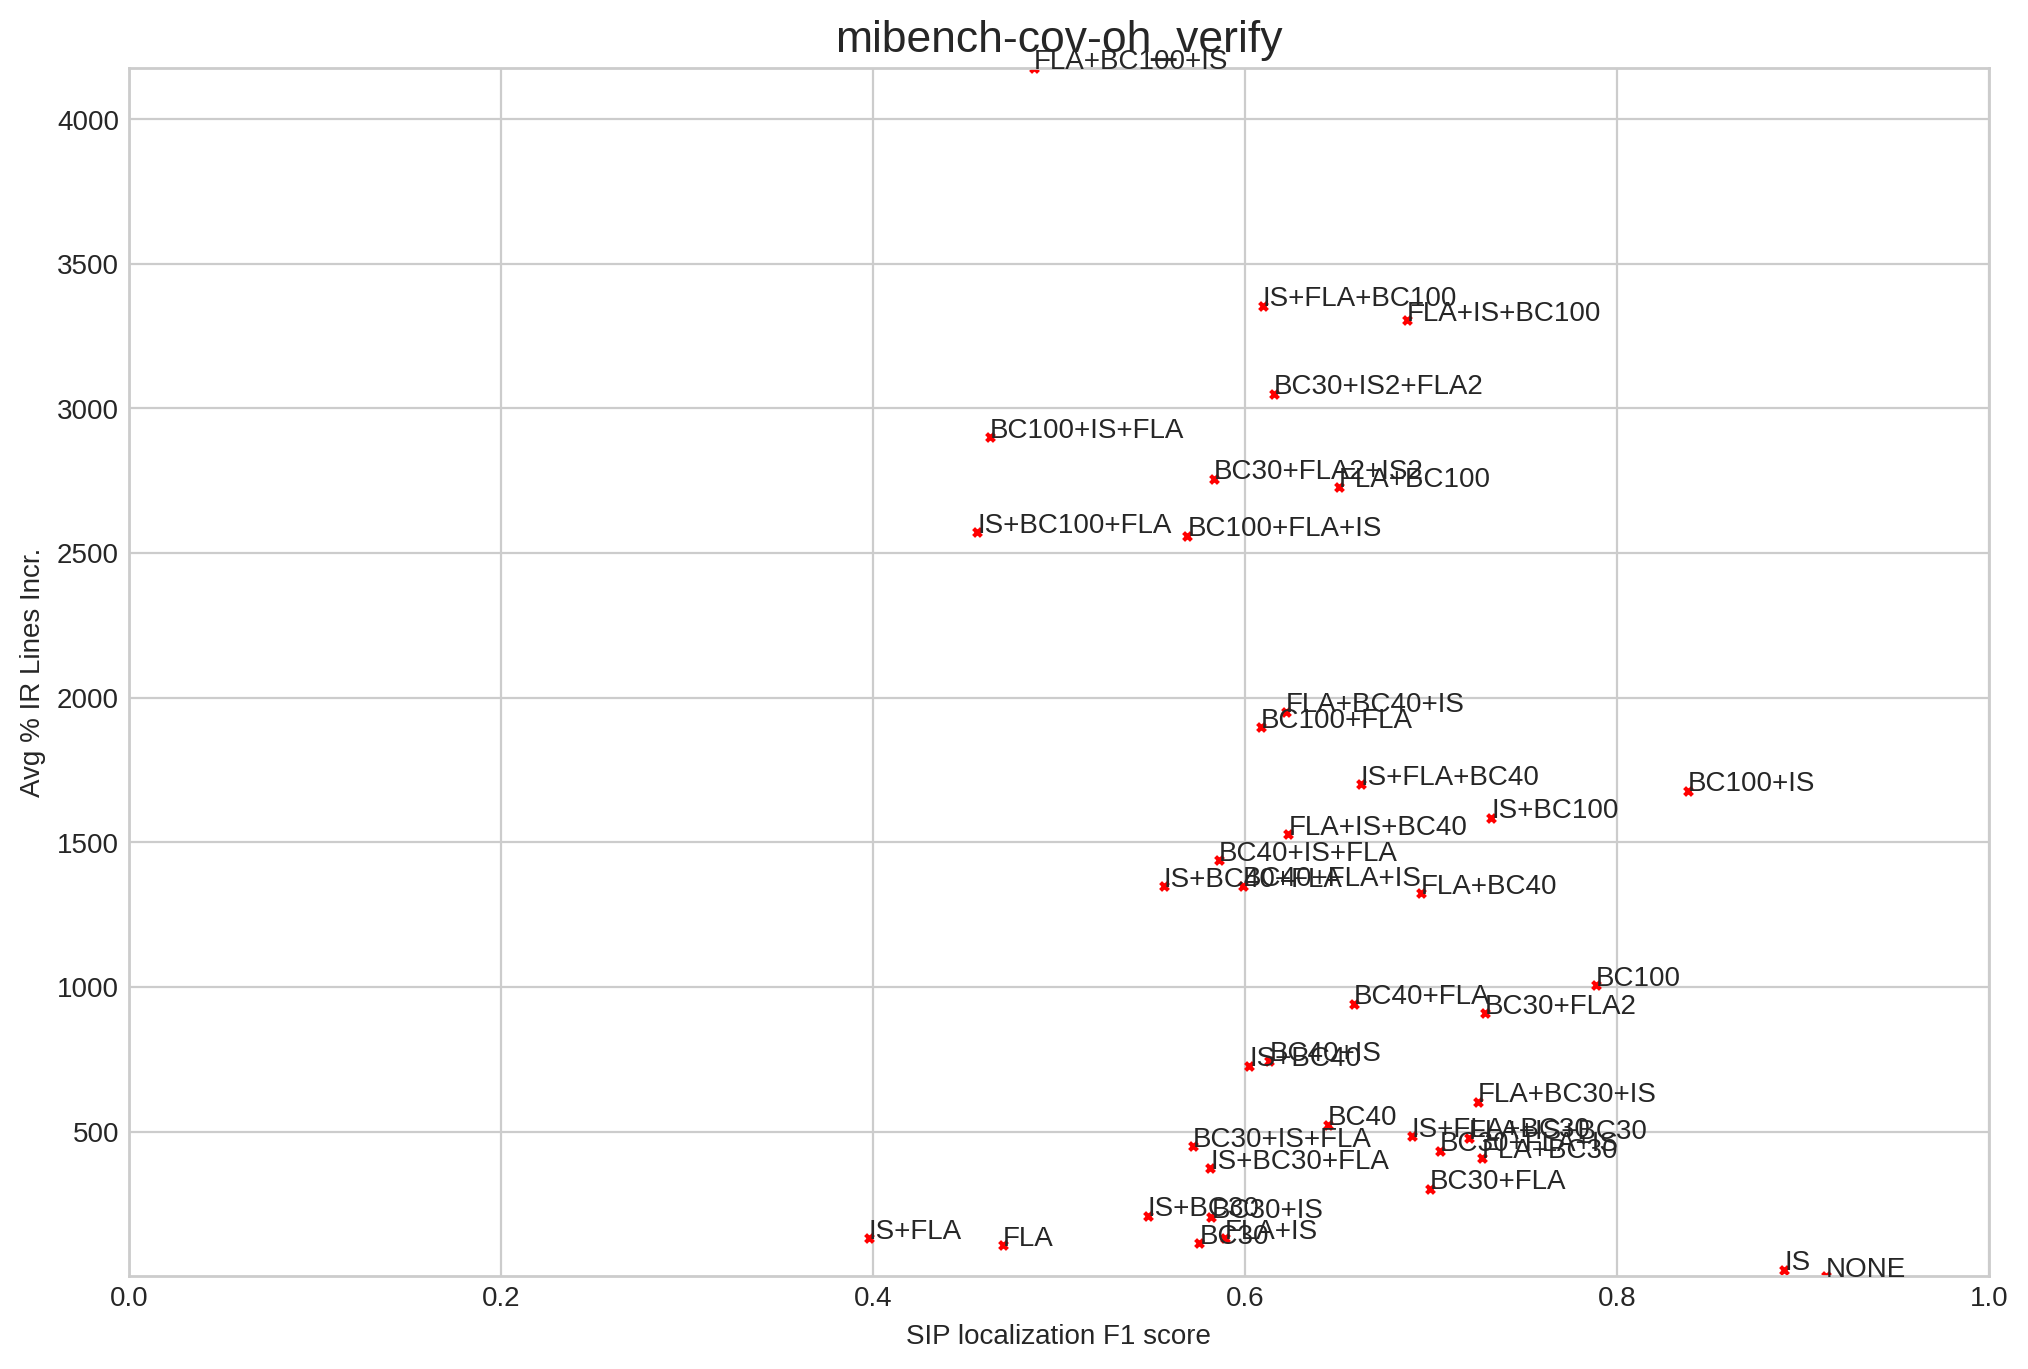

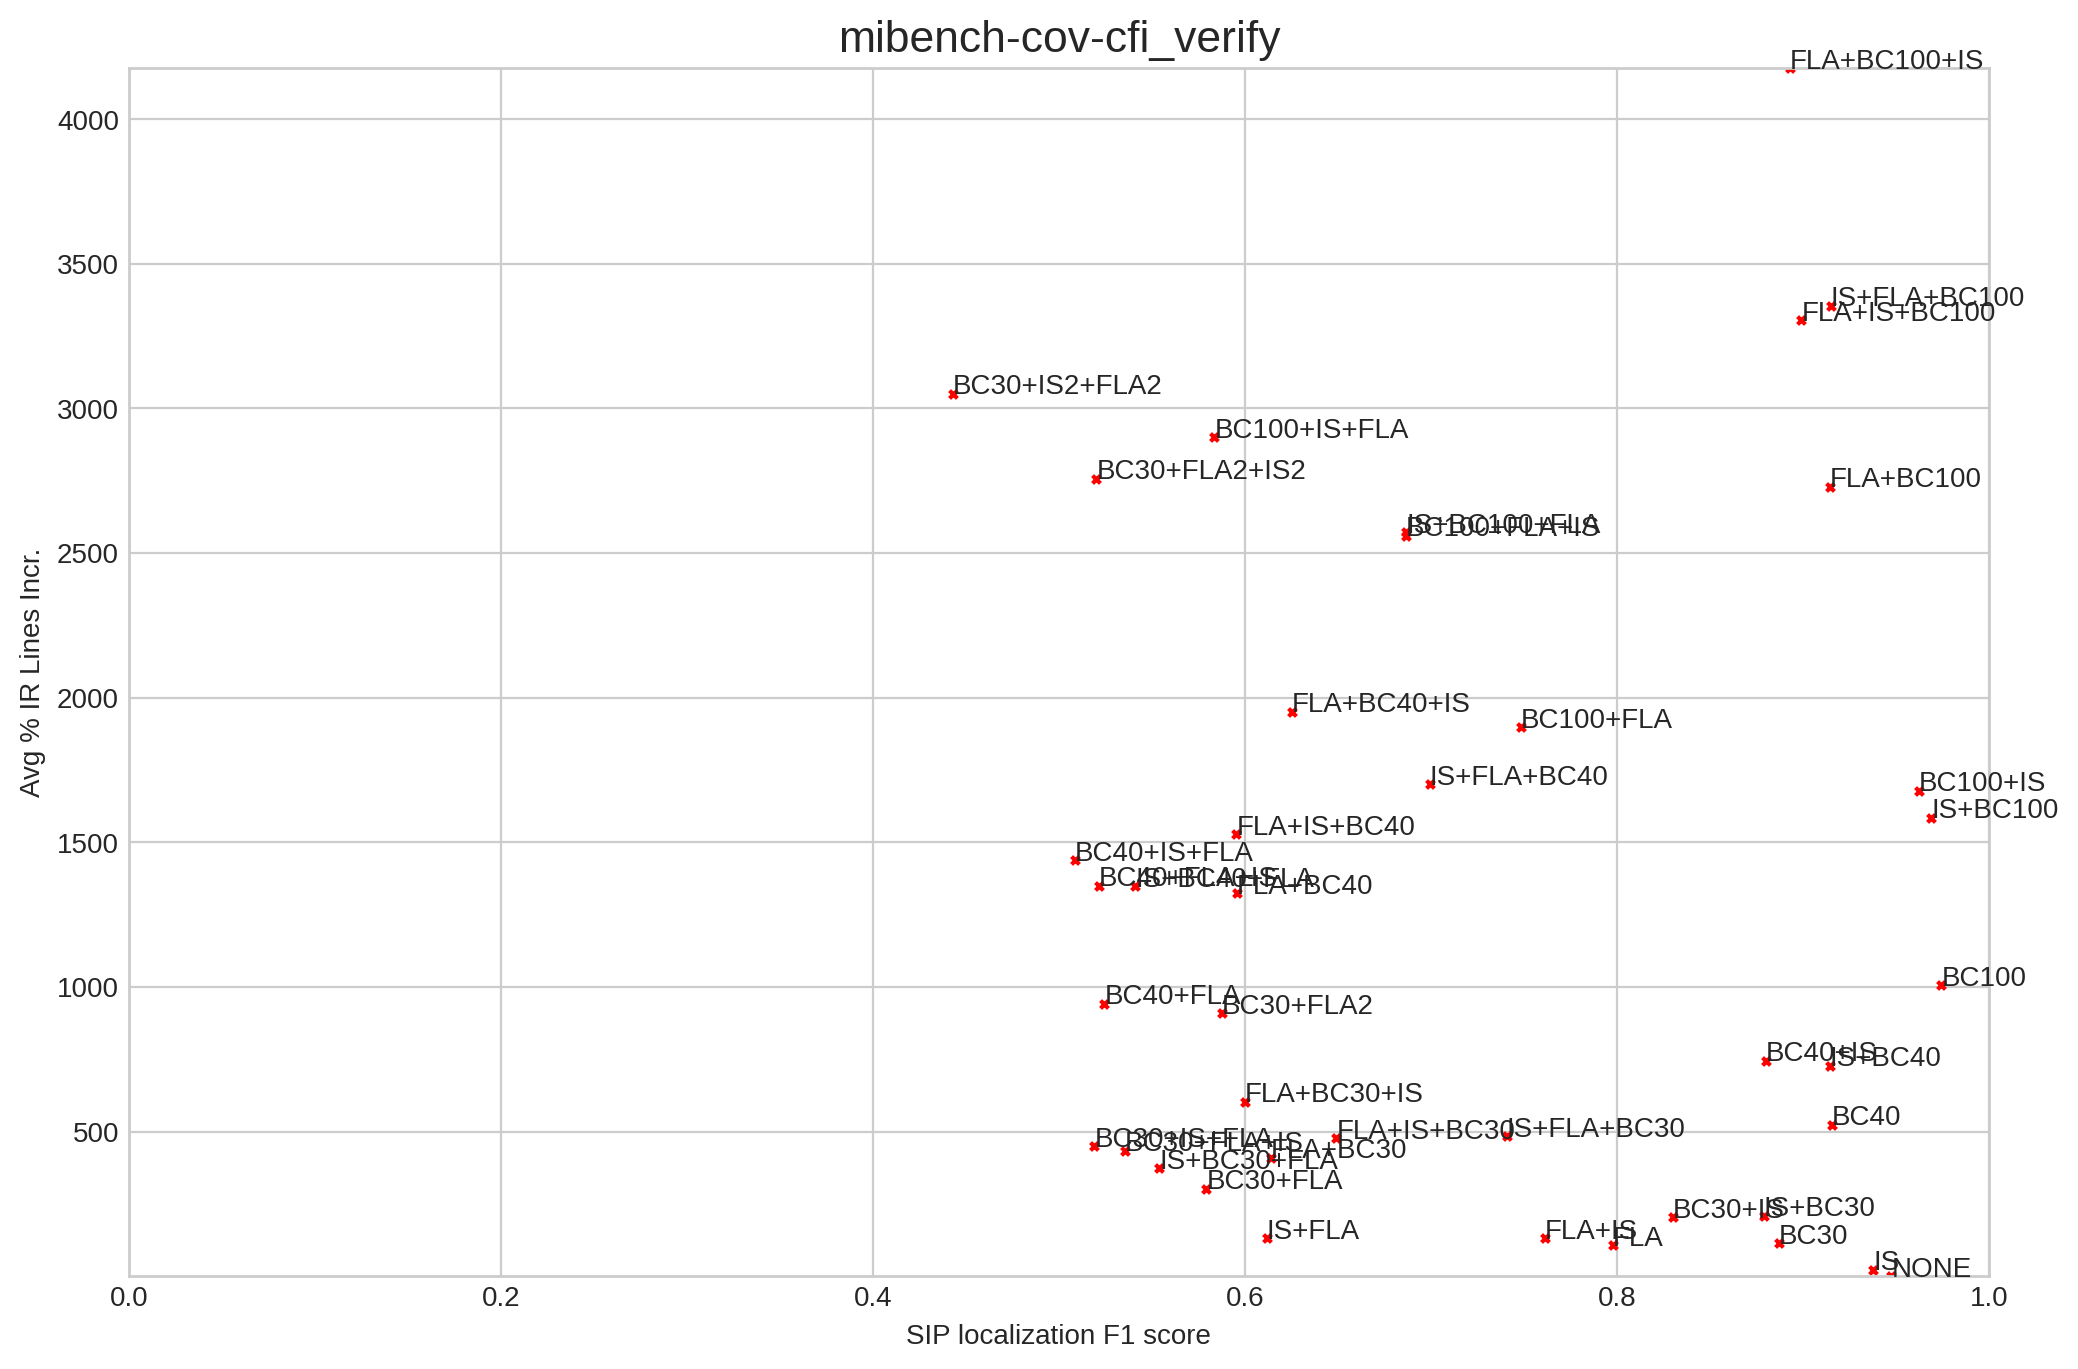

In [232]:
for src_dataset in ['simple-cov', 'mibench-cov']:
    for protection in ['sc_guard', 'oh_verify', 'cfi_verify']:
        plot_results = get_plot_results(df, src_dataset, protection)
        
        best_obfuscation_f1s = {}
        for obfuscation, results in plot_results.items():
            best_obfuscation_f1s[obfuscation] = max(map(median, results.values()))
        
        draw_scatter_plot(best_obfuscation_f1s, obfs_stats, f'{src_dataset}-{protection}')